<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

###  Big Query, SQL, Classification

---

### The Data

There are 5 individual tables that have the information, contained in a Google BigQuery database.  The setup info for BigQuery is located on our DSI wiki.  You will have to query with SQL, the dataset in order to complete this project.

The tables, with cooresonding attributes that exist are:

### businesses
- business_id: unique business identifier
- name: name of the business
- review_count: number of reviews per business
- city: city business resides in
- stars: average rating
- categories: categories the business falls into (can be one or multiple)
- latitude
- longitude
- neighborhoods: neighborhoods business belongs to
- variable: "property" of the business (a tag)
- value: True/False for the property

### reviews
- user_id: unique user identifier
- review_id: unique review identifier
- votes.cool: how many thought the review was "cool"
- business_id: unique business id the review is for
- votes.funny: how many thought the review was funny
- stars: rating given
- date: date of review
- votes.useful: how many thought the review was useful
- ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review

### users
- yelping_since: signup date
- compliments.plain: # of compliments "plain"
- review_count: # of reviews:
- compliments.cute: total # of compliments "cute"
- compliments.writer: # of compliments "writer"
- compliments.note: # of compliments "note" (not sure what this is)
- compliments.hot: # of compliments "hot" (?)
- compliments.cool: # of compliments "cool"
- compliments.profile: # of compliments "profile"
- average_stars: average rating
- compliments.more: # of compliments "more"
- elite: years considered "elite"
- name: user's name
- user_id: unique user id
- votes.cool: # of votes "cool"
- compliments.list: # of compliments "list"
- votes.funny: # of compliments "funny"
- compliments.photos: # of compliments "photos"
- compliments.funny: # of compliments "funny"
- votes.useful: # of votes "useful"

### checkins
- business_id: unique business identifier
- variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
- value: # of checkins at that time

### tips
- user_id: unique user identifier
- business_id: unique business identifier
- likes: likes that the tip has
- date: date of tip
- ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip


The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. We're not sure whether the compliments or votes are by the user or for the user.

Full details about this dataset area located here:
https://bigquery.cloud.google.com/dataset/bigquery-dsi-dave:yelp_arizona

---


If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

- Phoenix
- Surprise
- Las Vegas
- Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because we thought the mix of them was funny:

- Airports
- Breakfast & Brunch
- Bubble Tea
- Burgers
- Bars
- Bakeries
- Breweries
- Cafes
- Candy Stores
- Comedy Clubs
- Courthouses
- Dance Clubs
- Fast Food
- Museums
- Tattoo
- Vape Shops
- Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Load your dataset(s) / setup / configure GBQ connection

---

Information about this dataset is located here:


**If you haven't done so, setup a project with the Google developer portal, following the directions here: [Getting Started with BigQuery](https://github.com/ga-students/DSI-SF-4/wiki/Getting-Started-with-BigQuery)**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
import scipy.stats as stats

import patsy

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import (precision_recall_curve, average_precision_score, f1_score)
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('fivethirtyeight')

sqlite_db = 'bigquery-dsi-dave:yelp_arizona.reviews'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

project_id = "bigquery-dsi-spencer"


In [2]:
# sql = """
# SELECT * FROM [bigquery-dsi-dave:yelp_arizona.reviews] 
# LIMIT 3000
# """

# reviews = pd.read_gbq(sql, project_id=project_id)

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 3000 rows.

Total time taken 6.68 s.
Finished at 2016-12-19 10:37:38.


In [5]:
reviews.to_csv('reviews_changed.csv', encoding='utf-8')

In [6]:
reviews = pd.read_csv('../../../Desktop/DSI-SF-4-seporter11/project-04/reviews_changed.csv')

In [13]:
reviews.drop('Unnamed: 0.1', axis=1, inplace=True)

In [14]:
reviews.head()

,user_id,review_id,votes_cool,business_id,votes_funny,stars,date,votes_useful,minutes_10,minutes_15,...,service_great,staff_friendly,super_friendly,sweet_potato,tasted_like,time_vegas,try_place,ve_seen,ve_tried,wait_staff
0,ZaLZYDB-HeFAZKMIjNyCyA,qlpTJ9sHAh24TdQIKb2ZFw,0,qsWxbgQwuomXvMseg23DGg,0,1,2014-06-08,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TjsABzuLx7k4sQG_L3txgg,eyEWPJaU2RwIareTyt8I-w,0,FKHv7FkblONv9qqBndJUrg,1,1,2013-03-29,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ofxlhi_HKp7myFDpwg9aIA,YMMWSqFhGT6IbWfcOmbTuw,0,K9fIADfO_zKFPFm75A1Hxw,0,1,2009-04-22,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-Rwn_JlLqNEhQIaiA8gFlw,9Efbx9dLzU0Lb3123_lErw,0,UxvOXcoCRFRAVhRB0D9imw,0,1,2014-03-24,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ajzzOmblivZzKJ6nLmtdjA,dOvVn6FJBTkcSPYuhtL5Ug,0,-xLwGUmmyKgsTtFOOXzjeg,0,1,2015-09-12,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# sql = """
# SELECT * FROM [bigquery-dsi-dave:yelp_arizona.businesses]
# """
# businesses = pd.read_gbq(sql, project_id=project_id)

Requesting query... ok.
Query running...
Query done.
Processed: 25.2 Mb

Retrieving results...
  Got page: 1; 21.0% done. Elapsed 11.79 s.
  Got page: 2; 42.0% done. Elapsed 16.99 s.
  Got page: 3; 62.0% done. Elapsed 23.23 s.
  Got page: 4; 83.0% done. Elapsed 29.13 s.
  Got page: 5; 100.0% done. Elapsed 33.85 s.
Got 152832 rows.

Total time taken 38.79 s.
Finished at 2016-12-18 14:51:09.


In [363]:
businesses.to_csv('businesses_changed.csv', encoding='utf-8')

In [364]:
businesses = pd.read_csv('../../../Desktop/DSI-SF-4-seporter11/project-04/businesses_changed.csv')

In [365]:
businesses.drop('Unnamed: 0', axis=1, inplace=True)

In [366]:
businesses.head()

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,XziiAJUc8cgj3McljtnYVw,Johnny Rockets,39,Las Vegas,3.0,"['Burgers', 'American (Traditional)', 'Sandwic...",36.114471,-115.169292,['The Strip'],attributes.Ambience.trendy,False
1,XziiAJUc8cgj3McljtnYVw,Johnny Rockets,39,Las Vegas,3.0,"['Burgers', 'American (Traditional)', 'Sandwic...",36.114471,-115.169292,['The Strip'],hours.Wednesday.close,False
2,XziiAJUc8cgj3McljtnYVw,Johnny Rockets,39,Las Vegas,3.0,"['Burgers', 'American (Traditional)', 'Sandwic...",36.114471,-115.169292,['The Strip'],hours.Monday.close,False
3,XziiAJUc8cgj3McljtnYVw,Johnny Rockets,39,Las Vegas,3.0,"['Burgers', 'American (Traditional)', 'Sandwic...",36.114471,-115.169292,['The Strip'],attributes.Good For Groups,True
4,XziiAJUc8cgj3McljtnYVw,Johnny Rockets,39,Las Vegas,3.0,"['Burgers', 'American (Traditional)', 'Sandwic...",36.114471,-115.169292,['The Strip'],hours.Monday.open,False


In [38]:
# sql = """
# SELECT * FROM [bigquery-dsi-dave:yelp_arizona.checkins] 
# LIMIT 3000
# """

# checkins = pd.read_gbq(sql, project_id=project_id)

Requesting query... ok.
Query running...
Query done.
Processed: 9.8 Mb

Retrieving results...
Got 3000 rows.

Total time taken 1.25 s.
Finished at 2016-12-18 15:09:38.


In [17]:
checkins.to_csv('checkins_changed.csv', encoding='utf-8')

In [16]:
checkins = pd.read_csv('../../../Desktop/DSI-SF-4-seporter11/project-04/checkins_changed.csv')

In [18]:
checkins.drop('Unnamed: 0', axis=1, inplace=True)

In [19]:
checkins.head()

,business_id,variable,value
0,0kZ4aYmqf5fzTt9Yvz8Kvw,checkin_info.0-0,1.0
1,PttpsvUJJiIyLd3ZjSnjCQ,checkin_info.0-0,1.0
2,3fA43apyr5i8PAm0Az04hQ,checkin_info.0-0,1.0
3,S3iZm7-MKPhvXWZRPqC_Og,checkin_info.0-0,1.0
4,_I-hcsM-TFQkBgSjpk7JLQ,checkin_info.0-0,1.0


In [42]:
# sql = """
# SELECT * FROM [bigquery-dsi-dave:yelp_arizona.tips] 
# LIMIT 3000
# """

# tips = pd.read_gbq(sql, project_id=project_id)

Requesting query... ok.
Query running...
Query done.
Processed: 84.0 Mb

Retrieving results...
Got 3000 rows.

Total time taken 6.16 s.
Finished at 2016-12-18 15:10:17.


In [64]:
tips.to_csv('tips_changed.csv', encoding='utf-8')

In [20]:
tips = pd.read_csv('../../../Desktop/DSI-SF-4-seporter11/project-04/tips_changed.csv')

In [23]:
tips.drop('Unnamed: 0', axis=1, inplace=True)

In [24]:
tips.head()

,user_id,business_id,likes,date,hours_24,amazing_food,animal_style,awesome_food,awesome_place,awesome_service,...,service_good,service_great,slow_service,staff_friendly,staff_great,steak_eggs,super_friendly,sweet_potato,velvet_pancakes,worth_wait
0,VkTuaLUtRDIioAeicDGang,--jFTZmywe7StuZ2hEjxyA,0,2012-01-04,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3yLjzX-5AU76zIEkmUpiMQ,--jFTZmywe7StuZ2hEjxyA,0,2013-09-03,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DDvHjP7wh5bqmIfqjcdwWw,--jFTZmywe7StuZ2hEjxyA,0,2013-05-18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,fx1jNuoZjyn0t5g2KUeksw,-0HGqwlfw3I8nkJyMHxAsQ,0,2014-02-15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,x0oIvyOtyH3rUDCfuUN40Q,-0HGqwlfw3I8nkJyMHxAsQ,0,2014-05-23,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [269]:
# sql = """
# SELECT * FROM [bigquery-dsi-dave:yelp_arizona.users] 
# """

# users = pd.read_gbq(sql, project_id=project_id)

In [244]:
users.to_csv('users_changed.csv', encoding='utf-8')

In [245]:
users = pd.read_csv('../../../Desktop/DSI-SF-4-seporter11/project-04/users_changed.csv')

In [247]:
users.drop('Unnamed: 0', axis=1, inplace=True)

In [246]:
users.head()

,Unnamed: 0,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,...,compliments_more,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful
0,0,2015-01,NaN,1,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],Scott,dMeSxE7S6Yxhz3cBgd6Sjw,0,NaN,0,NaN,NaN,0
1,1,2015-01,NaN,1,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],Diego,c-e0BxGy3eNtKzKDrrHyGw,0,NaN,0,NaN,NaN,0
2,2,2015-01,NaN,2,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],Katie,tO-IKvmHn9kGobTcVweTeA,0,NaN,0,NaN,NaN,0
3,3,2015-01,NaN,9,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],Ross,soPELsow5JAqNSYCUmntJg,2,NaN,1,NaN,NaN,0
4,4,2015-01,NaN,2,NaN,NaN,0,NaN,NaN,NaN,...,NaN,[],Pam,RR6dZa6dkrcgjKvEnI-Myw,0,NaN,0,NaN,NaN,0


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

*Research location data to find the city targets.*

In [402]:
#I first checked to see what the average rating for Vegas is in comparison to the other cities in the table. Given the 
#fact that the average for Phoenix is higher than that of Vegas, I can say that the 'stars' column is not a great
#predictor of Vegas. 

businesses.groupby(['city'])['stars'].mean()

city
Las Vegas    3.474983
Phoenix      3.489471
Surprise     3.017989
Waterloo     3.520645
Name: stars, dtype: float64

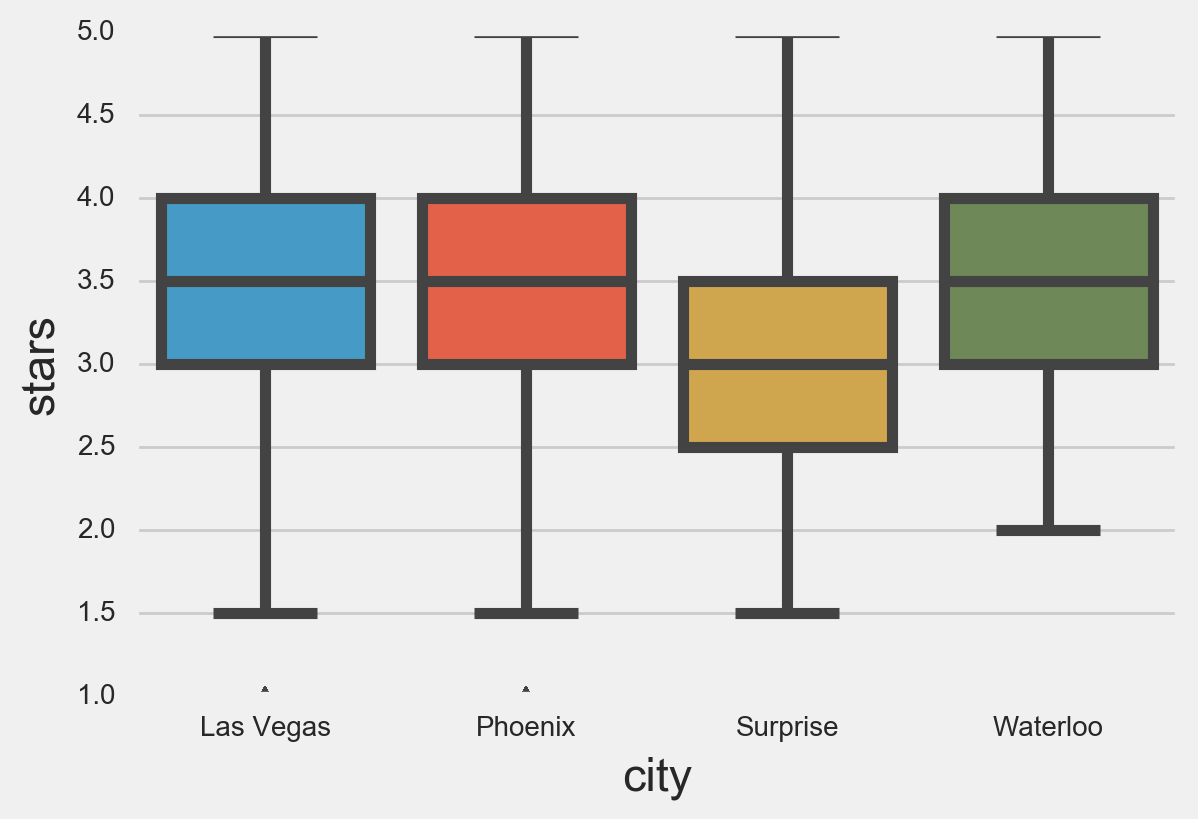

In [424]:
#the boxplot below further proves the fact that 'stars' is not a great predictor for Vegas.

sns.boxplot(x='city', y='stars', data=businesses)

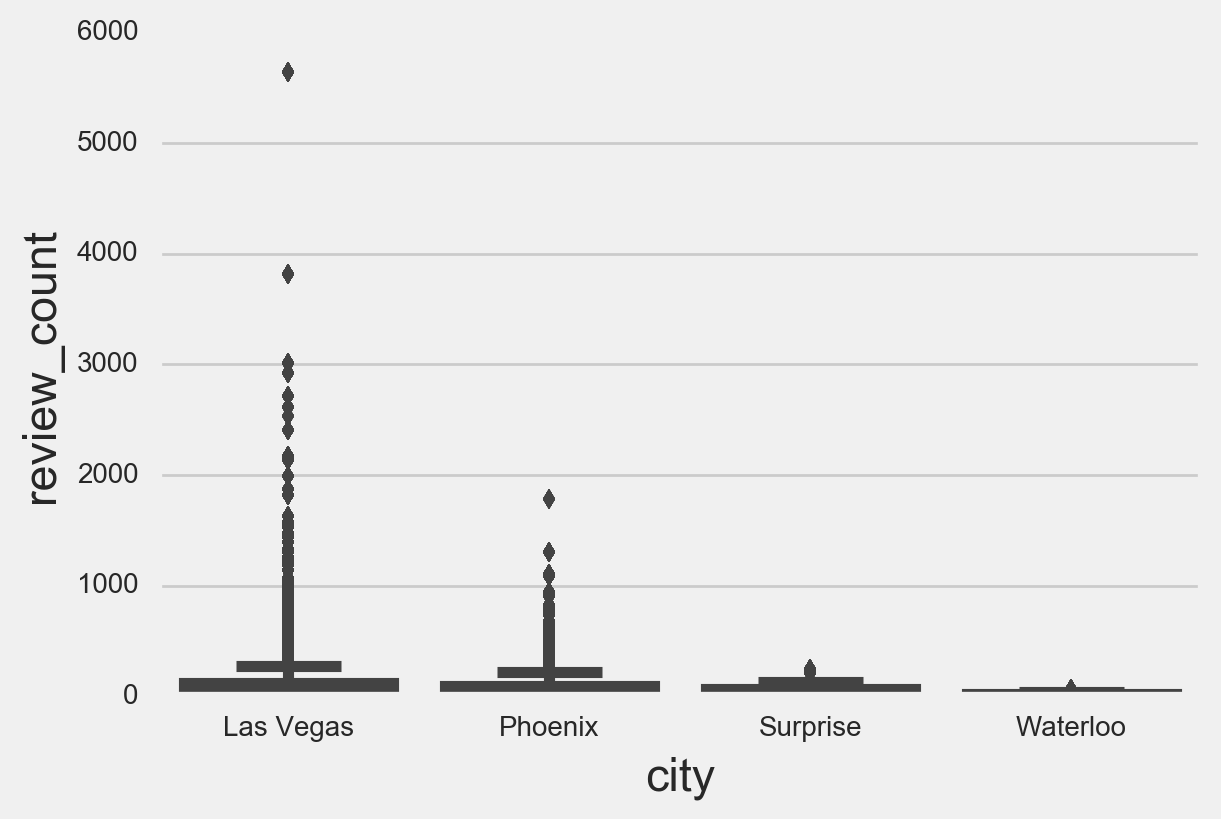

In [426]:
#I then wanted to check to see if the number of reviews would be more in Vegas than in the other cities, which it is.
#However, this is expected because obviously the number of reviews in Vegas will be higher than the other cities
#since there are definitely more businesses in Vegas. 

sns.boxplot(x='city', y='review_count', data=businesses)

In [392]:
businesses.groupby(['city'])['review_count'].count()

city
Las Vegas    93818
Phoenix      53279
Surprise      2974
Waterloo      2761
Name: review_count, dtype: int64

In [367]:
#I then wanted to transform my dataframe into a 'wide' format so that I could construct a regression model based on each
#variable as these seem to be the most unique for each city. I set up my columns for the new dataframe prior to running
#my pivot table.

cols = ['business_id', 'name', 'review_count', 'city', 'stars', 'categories', 'neighborhoods']

In [368]:
businesses_wide = pd.pivot_table(businesses, values='value', columns='variable', index=cols).reset_index()

In [369]:
businesses_wide.columns = businesses_wide.columns.str.replace(' ','_')
businesses_wide.columns = businesses_wide.columns.str.replace('attributes.','')
businesses_wide.columns = businesses_wide.columns.str.replace('.','_')
businesses_wide.columns = businesses_wide.columns.str.replace('-','')

In [370]:
businesses_wide.columns

Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'neighborhoods', u'Accepts_Credit_Cards',
       u'Accepts_Insurance', u'Ages_Allowed', u'Alcohol', u'Ambience_casual',
       u'Ambience_classy', u'Ambience_divey', u'Ambience_hipster',
       u'Ambience_intimate', u'Ambience_romantic', u'Ambience_touristy',
       u'Ambience_trendy', u'Ambience_upscale', u'Attire', u'BYOB',
       u'BYOB/Corkage', u'By_Appointment_Only', u'Caters', u'Coat_Check',
       u'Corkage', u'Delivery', u'Dietary_Restrictions_dairyfree',
       u'Dietary_Restrictions_glutenfree', u'Dietary_Restrictions_halal',
       u'Dietary_Restrictions_kosher', u'Dietary_Restrictions_soyfree',
       u'Dietary_Restrictions_vegan', u'Dietary_Restrictions_vegetarian',
       u'Dogs_Allowed', u'DriveThru', u'Good_For_Dancing', u'Good_For_Groups',
       u'Good_For_breakfast', u'Good_For_brunch', u'Good_For_dessert',
       u'Good_For_dinner', u'Good_For_latenight', u'Good_For_lunch',
 

In [371]:
businesses_wide = businesses_wide.fillna(0)

In [372]:
businesses_wide.drop(['stars', 'hours_Friday_close', 'hours_Friday_open', 'hours_Monday_close', 'hours_Monday_open',
                                   'hours_Saturday_close', 'hours_Saturday_open', 'hours_Sunday_close', 'hours_Sunday_open',
                                   'hours_Thursday_close', 'hours_Thursday_open', 'hours_Tuesday_close', 'hours_Tuesday_open',
                                   'hours_Wednesday_close', 'hours_Wednesday_open'], axis=1, inplace=True)

In [373]:
#I assigned the value 1 for rows that are Vegas, and 0 for those that aren't Vegas. I figured it would be better for 
#creating a model if the target was a binary value. I wanted to use logistic regression.

def vegas(x):
    if x == 'Las Vegas':
        return 1
    else:
        return 0

businesses_wide['city'] = businesses_wide['city'].map(vegas)

In [384]:
businesses_wide.head()

variable,business_id,name,review_count,city,categories,neighborhoods,Accepts_Credit_Cards,Accepts_Insurance,Ages_Allowed,Alcohol,...,Parking_valet,Parking_validated,Price_Range,Smoking,Takeout,Takes_Reservations,Waiter_Service,Wheelchair_Accessible,WiFi,open
0,--jFTZmywe7StuZ2hEjxyA,Subway,7,1,"['Fast Food', 'Sandwiches', 'Restaurants']",[],True,0,0,False,...,0,0,True,0,True,False,0,0,0,True
1,-0HGqwlfw3I8nkJyMHxAsQ,McDonald's,9,0,"['Burgers', 'Fast Food', 'Restaurants']",[],True,0,0,False,...,False,False,True,0,True,False,False,0,False,True
2,-0VK5Z1BfUHUYq4PoBYNLw,T Spot,5,1,"['Bars', 'Nightlife', 'Lounges']",['Eastside'],True,0,0,False,...,False,False,False,True,0,0,0,0,0,True
3,-0bUDim5OGuv8R0Qqq6J4A,IHOP,8,0,"['Bakeries', 'Food', 'Breakfast & Brunch', 'Re...",[],True,0,0,0,...,False,False,True,0,True,False,True,True,0,False
4,-1bOb2izeJBZjHC7NWxiPA,First Watch,120,0,"['Breakfast & Brunch', 'Cafes', 'American (Tra...",[],True,0,0,False,...,False,False,True,0,True,False,True,True,False,True


In [374]:
#Setting up my Patsy dataframes...

from matplotlib import pyplot as plt
import seaborn as sns
import patsy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import seaborn as sns

y, X = patsy.dmatrices("city ~ Alcohol + Ambience_casual + \
Ambience_classy + Ambience_romantic + Ambience_touristy + \
Ambience_trendy + Ambience_upscale + Good_For_Dancing + \
Good_For_Groups + Good_For_breakfast + Good_For_brunch + Good_For_dessert + Good_For_dinner + Good_For_latenight + \
Happy_Hour + Open_24_Hours + Outdoor_Seating + Smoking + Takeout + \
Takes_Reservations + WiFi - 1", data=businesses_wide, return_type="dataframe")

y = y.values.ravel()
print X.shape
print y.shape

(4132, 22)
(4132,)


In [284]:
from sklearn.grid_search import GridSearchCV
from sklearn import grid_search, datasets
from sklearn.preprocessing import StandardScaler

In [285]:
ss = StandardScaler()

Xn = ss.fit_transform(X)

lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 1000, 50)
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)

lr_gs.fit(Xn, y)
print lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    6.9s


{'penalty': 'l1', 'C': 20.408261224489795, 'solver': 'liblinear'}


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    7.7s finished


In [286]:
#I got a baseline accuracy of 0.62 when using the following parameters: penalty: l1, C: 20.408, solver: liblinear

print 'Logistic Regression:'
print best_lr

print 'Baseline accuracy:', np.mean(y)

Logistic Regression:
LogisticRegression(C=20.408261224489795, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Baseline accuracy: 0.621974830591


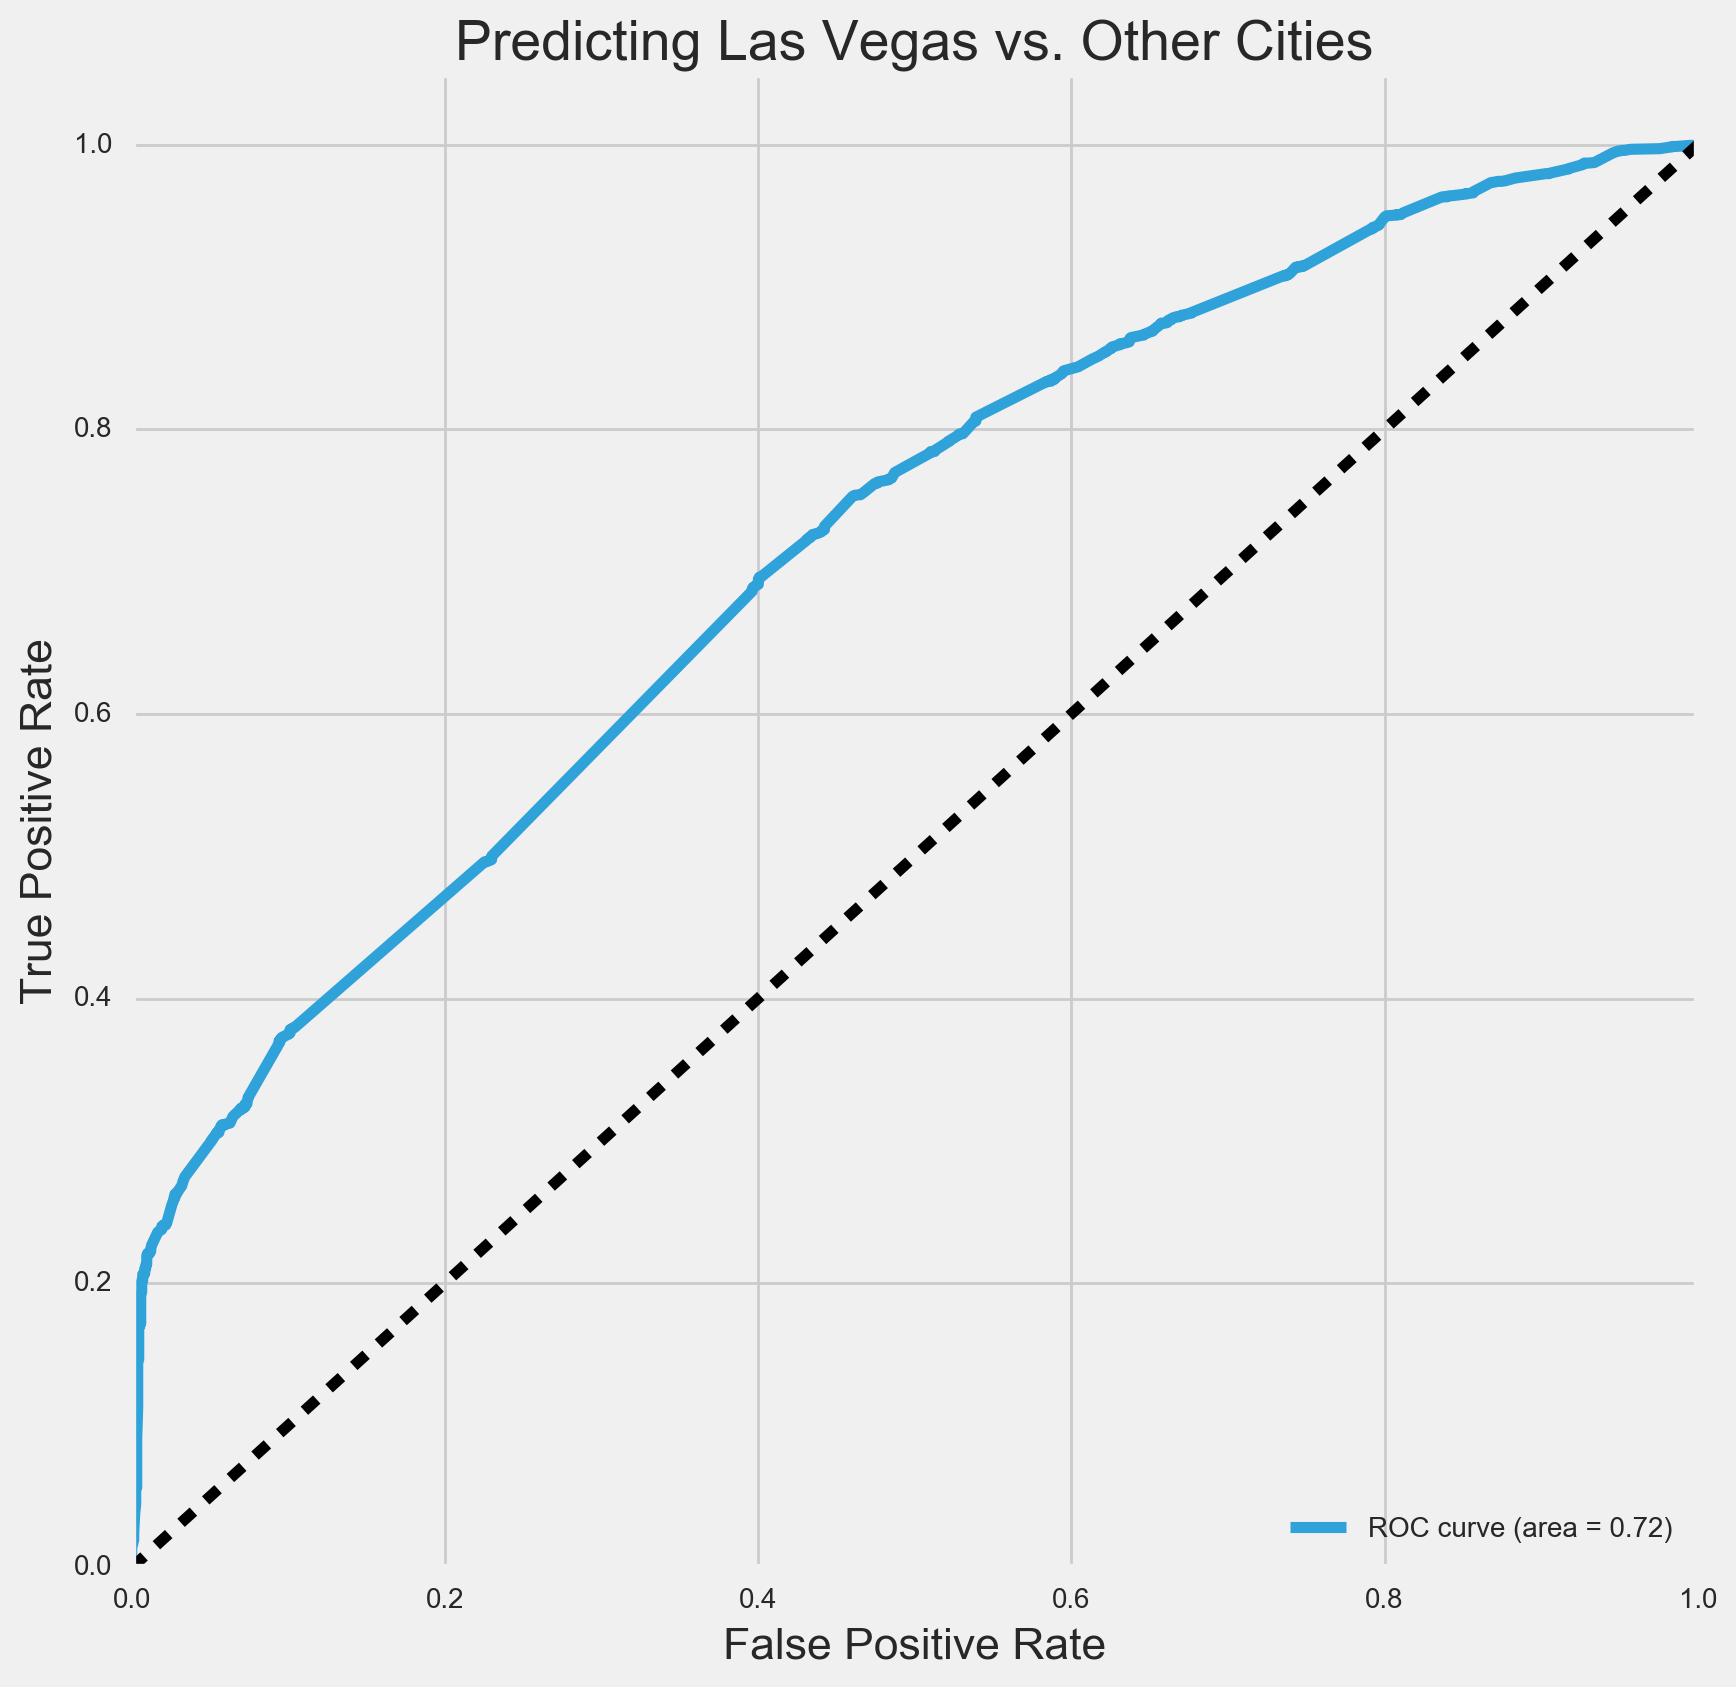

In [292]:
#I beat my baseline accuracy! 0.72 vs. 0.62.

from sklearn.metrics import roc_curve, auc

Xc = X - X.mean()

lr_centered = LogisticRegression()
lr_centered.fit(Xc, y)

y_pp = lr_centered.predict_proba(Xc)

fpr, tpr, _ = roc_curve(y, y_pp[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[9,9])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Predicting Las Vegas vs. Other Cities', fontsize=20)
plt.legend(loc="lower right")
plt.show()

Las Vegas Profile:

I looked data regarding Yelp reviews for four US cities: Las Vegas, Phoenix, Surprise and Waterloo. Through performing analysis over the data in a table called 'Businesses', I looked at multiple different variables to find which were good factors a restaurant should consider when deciding if they should open a restaurant in Vegas. 

Some of the factors included: serving alcohol , having a casual ambience , having a classy ambience , having a romantic ambience , having a touristy ambience , having a trendy ambience , having an upscale ambience , being good for dancing , being good for groups , being good for breakfast , being good for brunch , being good for dessert , being good for dinner , being good for late night , being good for happy hour , being open 24 hours , having outdoor seating , allowing smoking , having takeout options , taking reservations , having wifi.

I discovered that some factors that have strong correlations with the city of Las Vegas include being open for 24 hours, being good for late night, allowing smoking and having an upscale ambience. You can see the pointplots for further evidence below.

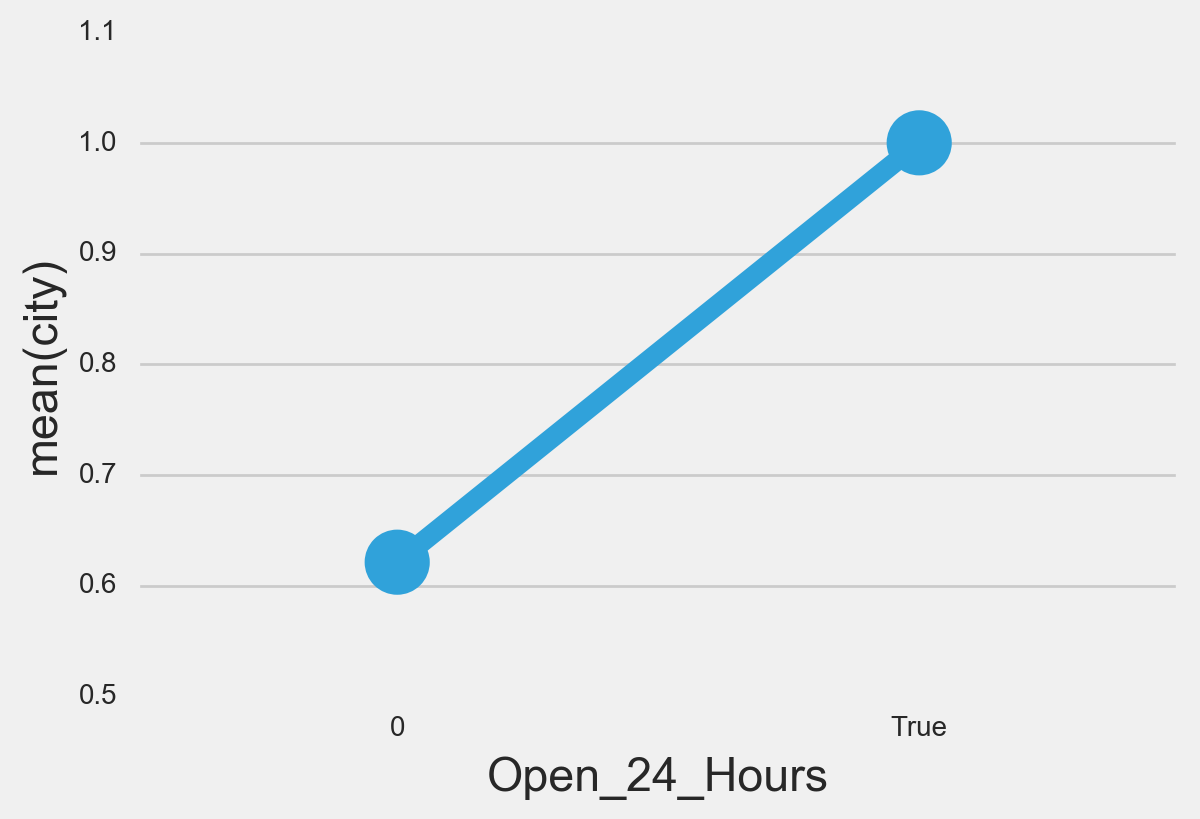

In [313]:
#If the business is open 24 hours a day, it is much more likely to be located in Vegas than other cities.

sns.pointplot(x= 'Open_24_Hours', y= 'city', data= businesses_wide)

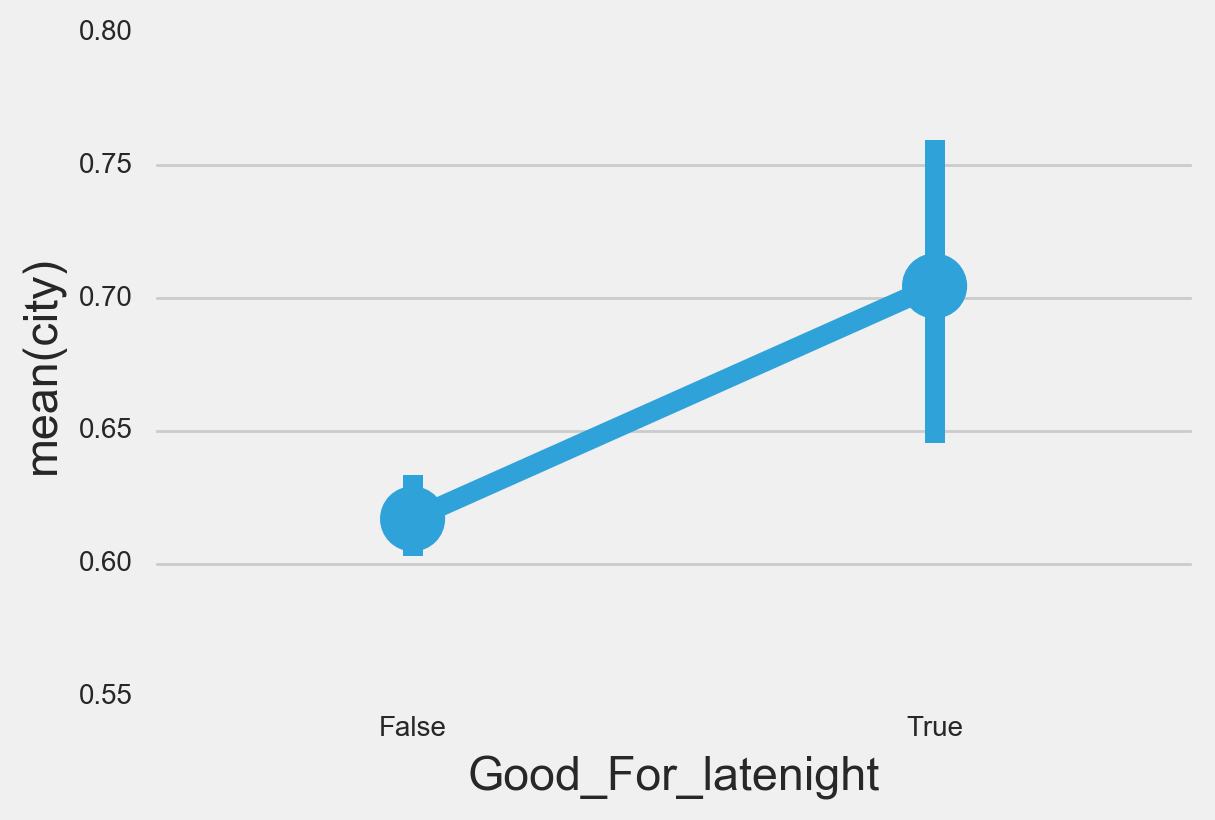

In [321]:
#Similarly, if it's open late, much more likely to be a Vegas establishment.

sns.pointplot(x= 'Good_For_latenight', y= 'city', data= businesses_wide)

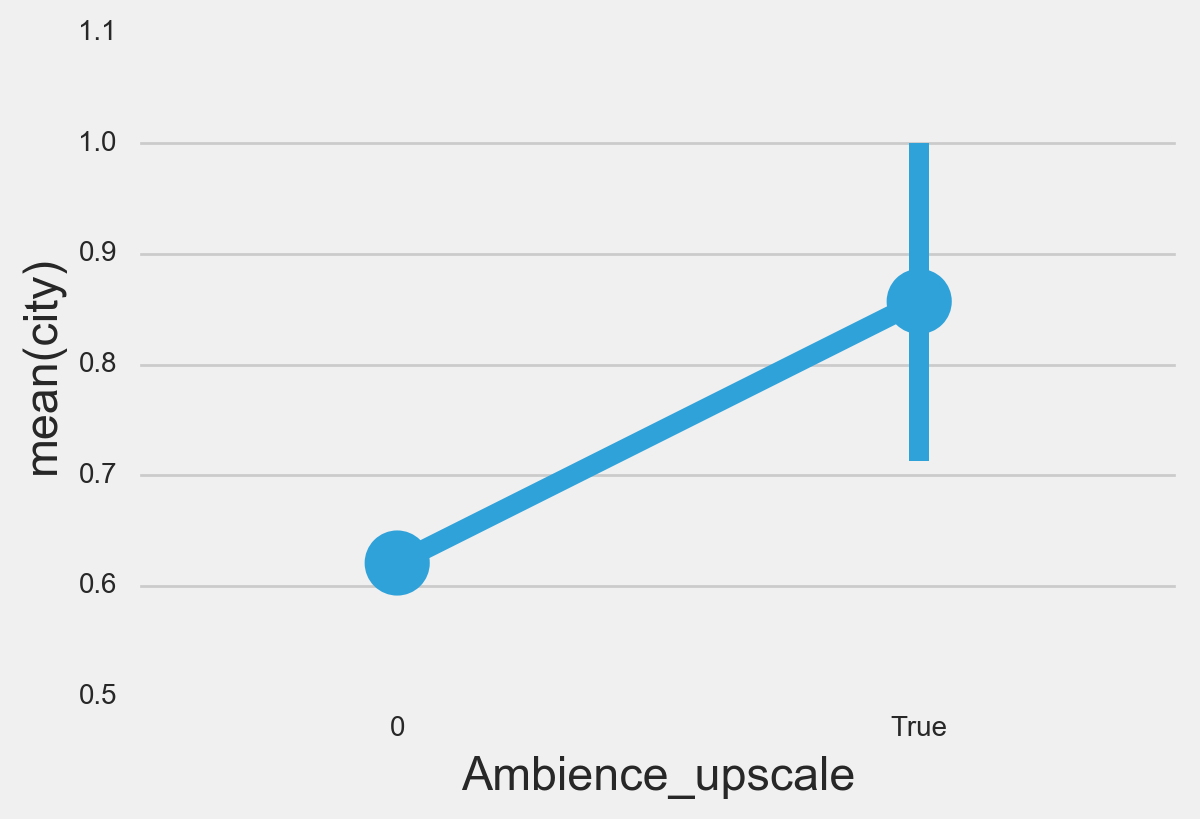

In [323]:
#Restaurants that are more upscale are more likely to be in Vegas.

sns.pointplot(x= 'Ambience_upscale', y= 'city', data= businesses_wide)

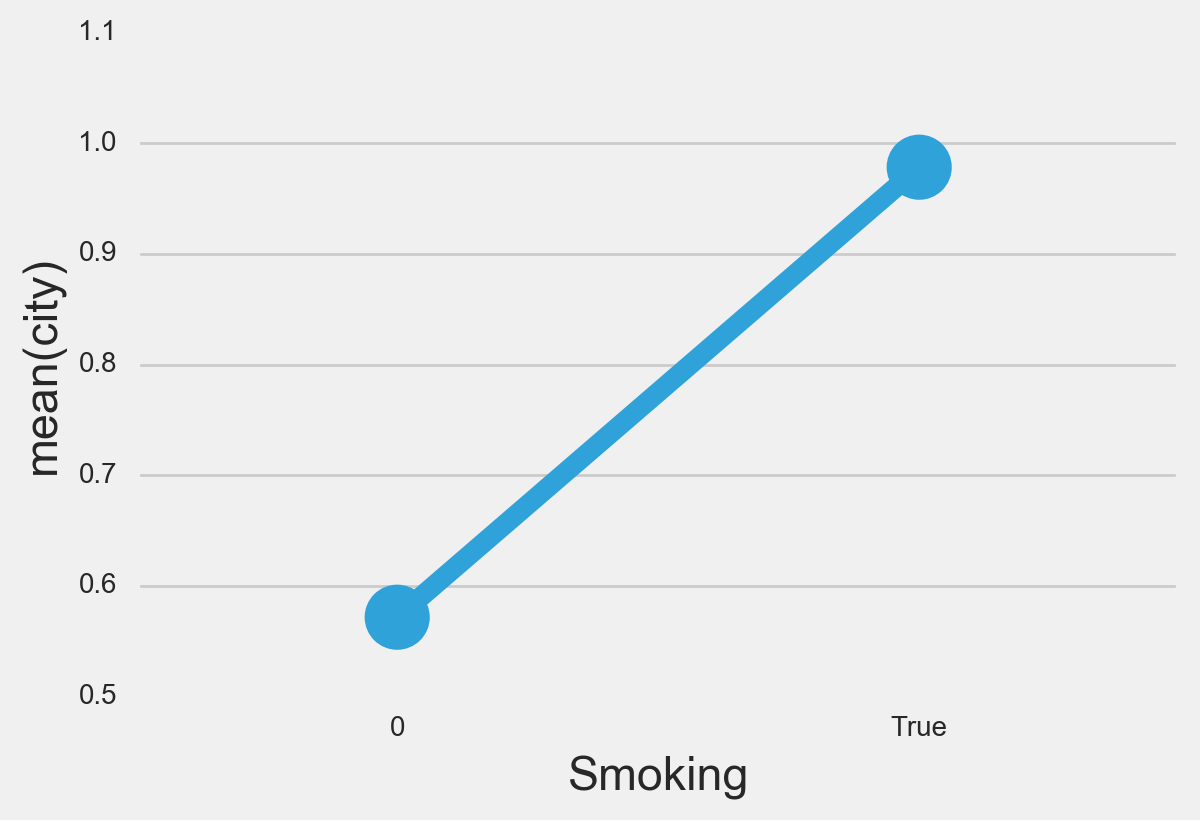

In [324]:
#Businesses that allow smoking are more likely to be in Vegas.

sns.pointplot(x= 'Smoking', y= 'city', data= businesses_wide)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [114]:
#I decided to use the reviews table to perform my analysis on. First wanted to see which variables I was working with.

for col in reviews:
    print col

user_id
review_id
votes_cool
business_id
votes_funny
stars
date
votes_useful
minutes_10
minutes_15
minutes_20
minutes_30
bar_food
beer_selection
best_ve
bloody_mary
bottle_service
chicken_waffles
customer_service
dance_floor
decided_try
definitely_come
definitely_recommend
didn_want
don_know
don_like
don_think
don_want
eggs_benedict
fast_food
feel_like
felt_like
fish_chips
food_amazing
food_came
food_delicious
food_good
food_great
food_just
food_service
french_fries
french_toast
friday_night
fried_chicken
friendly_staff
good_food
good_place
good_service
good_thing
good_time
great_atmosphere
great_experience
great_food
great_place
great_service
great_time
happy_hour
hash_browns
highly_recommend
hip_hop
ice_cream
just_like
just_ok
just_right
las_vegas
late_night
like_place
little_bit
long_time
looked_like
looks_like
love_place
mac_cheese
make_sure
mashed_potatoes
medium_rare
minutes_later
new_york
onion_rings
place_good
place_great
place_just
potato_fries
pretty_good
quality_food
really_

In [128]:
#Then I set up both the service focused categories as well as the non-service focused categories so that I could create
#my new columns.

service_focus = ['bottle_service', 'customer_service', 'customer_service', 'fast_food', 'feel_like', 'felt_like',
                  'food_came', 'food_service', 'friendly_staff', 'good_service', 'good_thing', 'good_time', 'great_atmosphere', 'great_place',
                  'great_service', 'great_experience', 'great_time', 'late_night', 'long_time', 'service_excellent, service_food', 'service_friendly', 'service_good', 'service_great',
                   'right_away', 'minutes_later', 'staff_friendly', 'super_friendly', 'wait_staff']
other_focus = ['minutes_10', 'minutes_15', 'minutes_20', 'minutes_30', 'bar_food', 'beer_selection', 'best_ve', 'bloody_mary', 'chicken_waffles', 'dance_floor', 'decided_try',
               'definitely_come', 'definitely_recommend', 'didn_want', 'don_know', 'don_like', 'don_think', 'don_want'
               'eggs_benedict', 'fish_chips', 'food_amazing', 'food_delicious', 'food_good', 'food_great', 'food_just',
               'french_fries', 'french_toast', 'fried_chicken', 'friday_night', 'good_food', 'good_place', 'good_thing', 'great_food',
               'hash_browns', 'happy_hour', 'hip_hop', 'highly_recommend', 'ice_cream', 'just_like', 'just_ok', 
               'just_right', 'las_vegas', 'like_place', 'little_bit', 'looked_like', 'looks_like', 'love_place'
               'mac_cheese', 'make_sure', 'mashed_potatoes', 'medium_rare', 'new_york', 'onion_rings', 'potato_fries', 'quality_food',
               'red_velvet', 'sweet_potato', 'tasted_like', 've_tried', 'place_good', 'place_great', 'place_just', 'pretty_good', 
               'really_enjoyed', 'really_good', 'really_like', 'really_nice', 'recommend_place', 'saturday_night', 'second_time',
               'time_vegas', 'try_place', 've_seen', 've_tried']

In [435]:
x_serv_cols = [x for x in reviews.columns if x in service_focus]
reviews['service'] = reviews.loc[:,x_serv_cols].sum(axis=1)

In [437]:
#I created columns only containing those variables that I deemed to be service related. 

x_serv_cols

['bottle_service',
 'customer_service',
 'fast_food',
 'feel_like',
 'felt_like',
 'food_came',
 'food_service',
 'friendly_staff',
 'good_service',
 'good_thing',
 'good_time',
 'great_atmosphere',
 'great_experience',
 'great_place',
 'great_service',
 'great_time',
 'late_night',
 'long_time',
 'minutes_later',
 'right_away',
 'service_friendly',
 'service_good',
 'service_great',
 'staff_friendly',
 'super_friendly',
 'wait_staff']

In [433]:
x_other_cols = [x for x in reviews.columns if x in other_focus]
reviews['other'] = reviews.loc[:,x_other_cols].sum(axis=1) 

In [436]:
#Then created columns only containing those variables I deemed to be non-service related.

x_other_cols

['minutes_10',
 'minutes_15',
 'minutes_20',
 'minutes_30',
 'bar_food',
 'beer_selection',
 'best_ve',
 'bloody_mary',
 'chicken_waffles',
 'dance_floor',
 'decided_try',
 'definitely_come',
 'definitely_recommend',
 'didn_want',
 'don_know',
 'don_like',
 'don_think',
 'fish_chips',
 'food_amazing',
 'food_delicious',
 'food_good',
 'food_great',
 'food_just',
 'french_fries',
 'french_toast',
 'friday_night',
 'fried_chicken',
 'good_food',
 'good_place',
 'good_thing',
 'great_food',
 'happy_hour',
 'hash_browns',
 'highly_recommend',
 'hip_hop',
 'ice_cream',
 'just_like',
 'just_ok',
 'just_right',
 'las_vegas',
 'like_place',
 'little_bit',
 'looked_like',
 'looks_like',
 'make_sure',
 'mashed_potatoes',
 'medium_rare',
 'new_york',
 'onion_rings',
 'place_good',
 'place_great',
 'place_just',
 'potato_fries',
 'pretty_good',
 'quality_food',
 'really_enjoyed',
 'really_good',
 'really_like',
 'really_nice',
 'recommend_place',
 'red_velvet',
 'saturday_night',
 'second_time',
 

In [434]:
reviews['service_rating'] = 1
reviews['other_rating'] = 1
reviews.loc[(reviews.service >= reviews.other),'service_rating'] = reviews.stars
reviews.loc[~(reviews.service >= reviews.other),'other_rating'] = reviews.stars

X_service =  reviews[x_serv_cols]
X_other = reviews[x_other_cols]
y_service = reviews['service_rating']
y_other = reviews['other_rating']                  

In [ ]:
#Loading up patsy...

import patsy

y, X = patsy.dmatrices("y_service ~ X_service - 1", data=reviews, return_type="dataframe")

y = y.values.ravel()

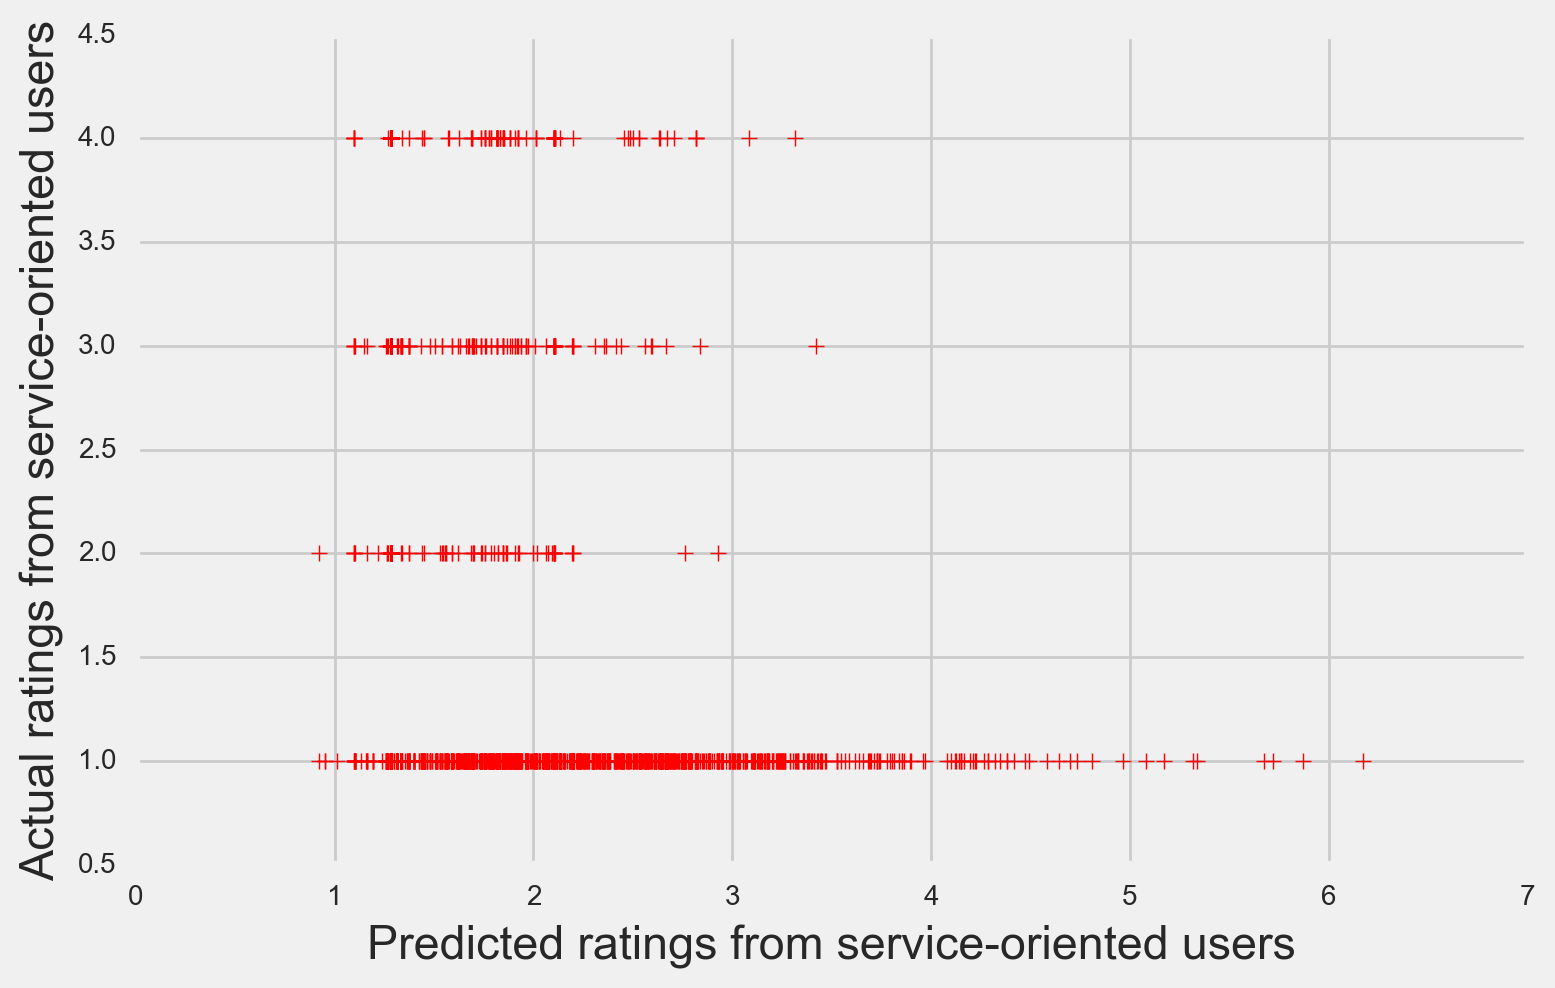

MSE: 2.45394693101

----------------
COEFS: [('X_other[0]', array([ 0.16855027,  0.0903266 , -0.1812187 ,  0.27909872,  0.72865085,
        1.28053867,  1.22110239,  0.54806256,  0.49285292,  0.45614978,
        0.39450934,  1.35664075,  1.25077084, -0.01439064,  0.31078737,
        0.45962608,  0.34111427,  0.28491696,  0.7016572 ,  1.09874983,
        0.81952966,  0.82504203, -0.01811367,  0.24876803,  0.41852689,
        0.41180671,  0.41282279,  0.56491533,  0.68176657, -0.18502503,
        0.64027425,  0.4754079 ,  0.15989698,  1.53766865,  0.3398868 ,
        0.11749969,  0.5068154 ,  0.62684716,  0.79027885,  0.40846524,
       -0.11731382,  0.05696278,  0.03022764,  0.58462264,  0.59924904,
        0.15412195,  0.25643445,  0.65226864,  0.27323044,  0.85401982,
        0.50603067,  0.40596933,  0.48195659,  0.91463244, -0.02168335,
        0.56927115,  0.53629151,  0.62535441,  0.78049697,  0.57200965,
        0.36713024,  0.56394313,  0.59791006,  0.54200106,  0.05430469,
    

In [347]:
#I decided to perform Linear Regression for this model. Pretty bad R^2 and MSE. Service oriented reviews are not good
#predictors of ratings.

lm = linear_model.LinearRegression()

model = lm.fit(X, y)
predictions = model.predict(X)

plt.figure(figsize=(8, 5))
plt.scatter(predictions, y_service, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted ratings from service-oriented users")
plt.ylabel("Actual ratings from service-oriented users")
plt.show()

print "MSE:", mean_squared_error(y_service, predictions)

print "\n----------------\nCOEFS:", zip(X.columns, model.coef_)
print "\n----------------\nR^2:", model.score(X, y)

In [348]:
#Loading patsy with the 'other' variables now..

y, X = patsy.dmatrices("y_other ~ X_other - 1", data=reviews, return_type="dataframe")

y = y.values.ravel()

print X.shape
print y.shape

(3000, 69)
(3000,)


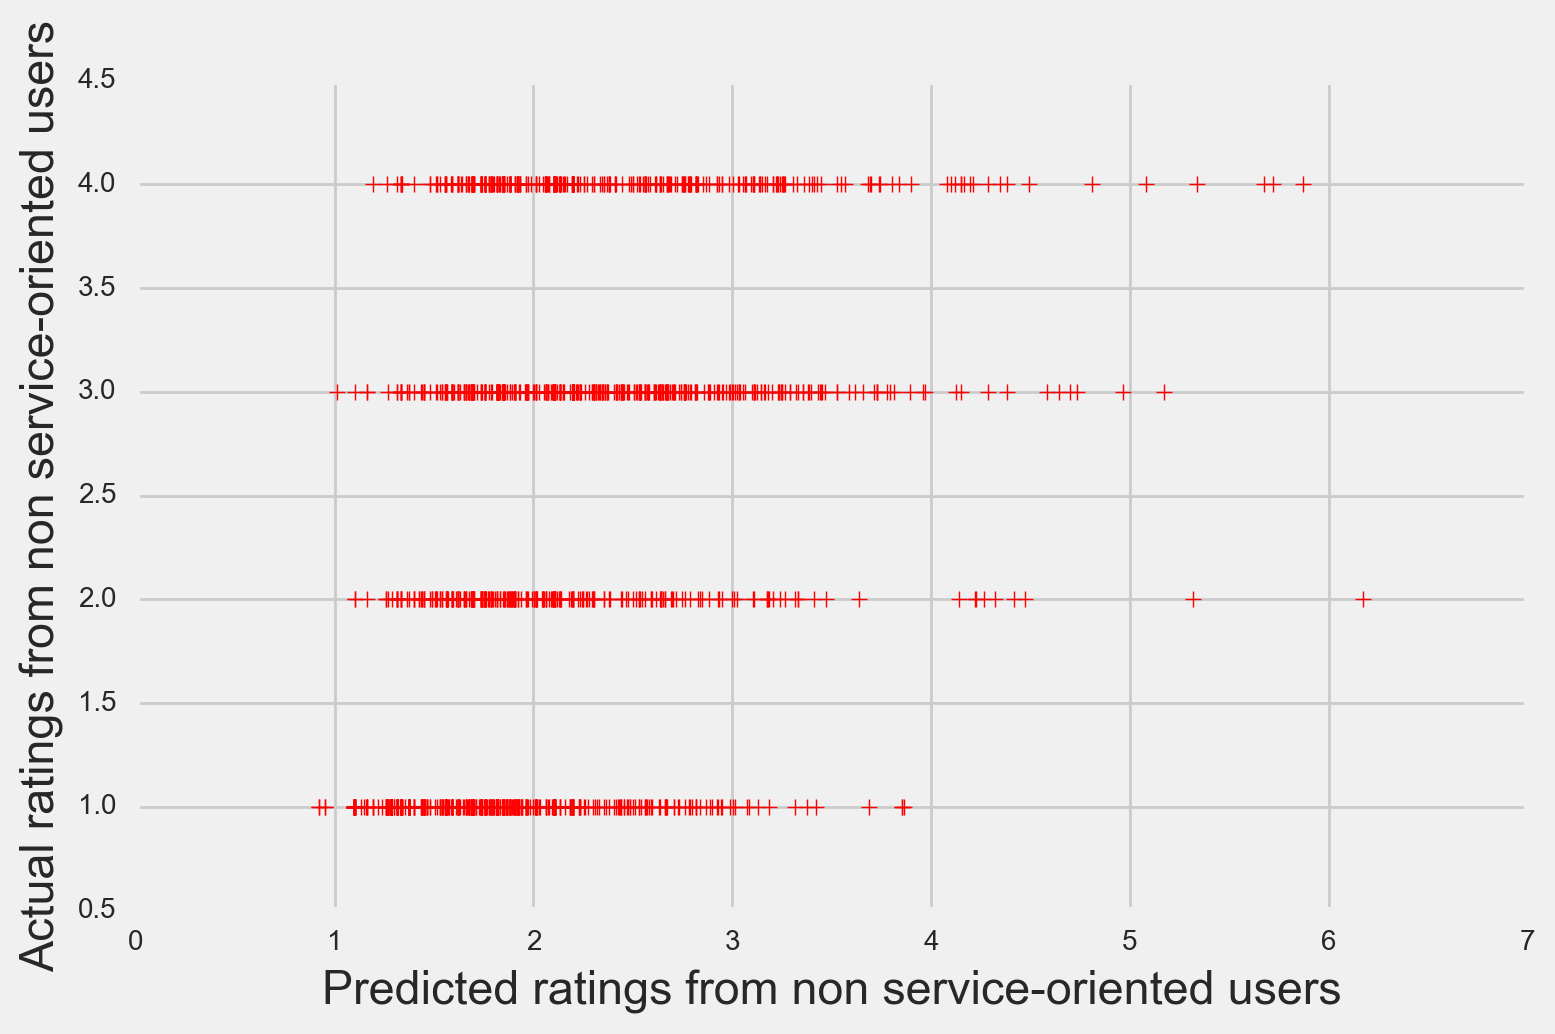

MSE: 0.767799972722

----------------
COEFS: [('X_other[0]', 0.16855026712511745), ('X_other[1]', 0.090326603033718367), ('X_other[2]', -0.18121870201334644), ('X_other[3]', 0.27909871650320844), ('X_other[4]', 0.7286508516868837), ('X_other[5]', 1.2805386704800239), ('X_other[6]', 1.2211023939087913), ('X_other[7]', 0.54806255946666871), ('X_other[8]', 0.49285291839622564), ('X_other[9]', 0.4561497762944815), ('X_other[10]', 0.39450933831500756), ('X_other[11]', 1.3566407535564269), ('X_other[12]', 1.2507708439208756), ('X_other[13]', -0.014390643926882593), ('X_other[14]', 0.31078736782945121), ('X_other[15]', 0.4596260759051784), ('X_other[16]', 0.34111426706992209), ('X_other[17]', 0.28491696132975947), ('X_other[18]', 0.70165720042351587), ('X_other[19]', 1.0987498291066811), ('X_other[20]', 0.81952965558554602), ('X_other[21]', 0.82504202942737037), ('X_other[22]', -0.018113667247924958), ('X_other[23]', 0.24876802633421852), ('X_other[24]', 0.41852688904392132), ('X_other[25]', 

In [350]:
#I got the same R^2 which seems weird to me, but a different MSE. Given the lower MSE, I'd say this model is a better
#predictor. Still terrible though. There is a slight difference in models between the service focused and non-service
#focused, however not a large difference by any means.

lm = linear_model.LinearRegression()

model = lm.fit(X, y)
predictions = model.predict(X)

plt.figure(figsize=(8, 5))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted ratings from non service-oriented users")
plt.ylabel("Actual ratings from non service-oriented users")
plt.show()

print "MSE:", mean_squared_error(y, predictions)

print "\n----------------\nCOEFS:", zip(X.columns, model.coef_)
print "\n----------------\nR^2:", model.score(X, y)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [248]:
#First I am checking to see if the 'elite' column has any data that could be indicative for if a user is elite or not.
#I discovered that if a user has a list of dates, they are/have been elite at some point, and alternatively if there
#is an empty list, the user has never been elite.

def check_if_elite(x):
    if x == '[]':
        return 0
    else:
        return 1

In [249]:
users['target'] = users['elite'].apply(check_if_elite)

In [250]:
#Making sure my function worked, which it did!

users[['name','target','elite']]

,name,target,elite
0,Scott,0,[]
1,Diego,0,[]
2,Katie,0,[]
3,Ross,0,[]
4,Pam,0,[]
5,Vishal,0,[]
6,Daniel,0,[]
7,Dave,0,[]
8,Lyan,0,[]
9,Breezy,0,[]


In [251]:
for col in users:
    print col

yelping_since
compliments_plain
review_count
compliments_cute
compliments_writer
fans
compliments_note
compliments_hot
compliments_cool
compliments_profile
average_stars
compliments_more
elite
name
user_id
votes_cool
compliments_list
votes_funny
compliments_photos
compliments_funny
votes_useful
target


In [252]:
def correlation_heat_map(df):
    corrs = df.corr()
    fig, ax = plt.subplots(figsize=(12,12))
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corrs, mask=mask, annot=True)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, rotation=0)
    plt.show()

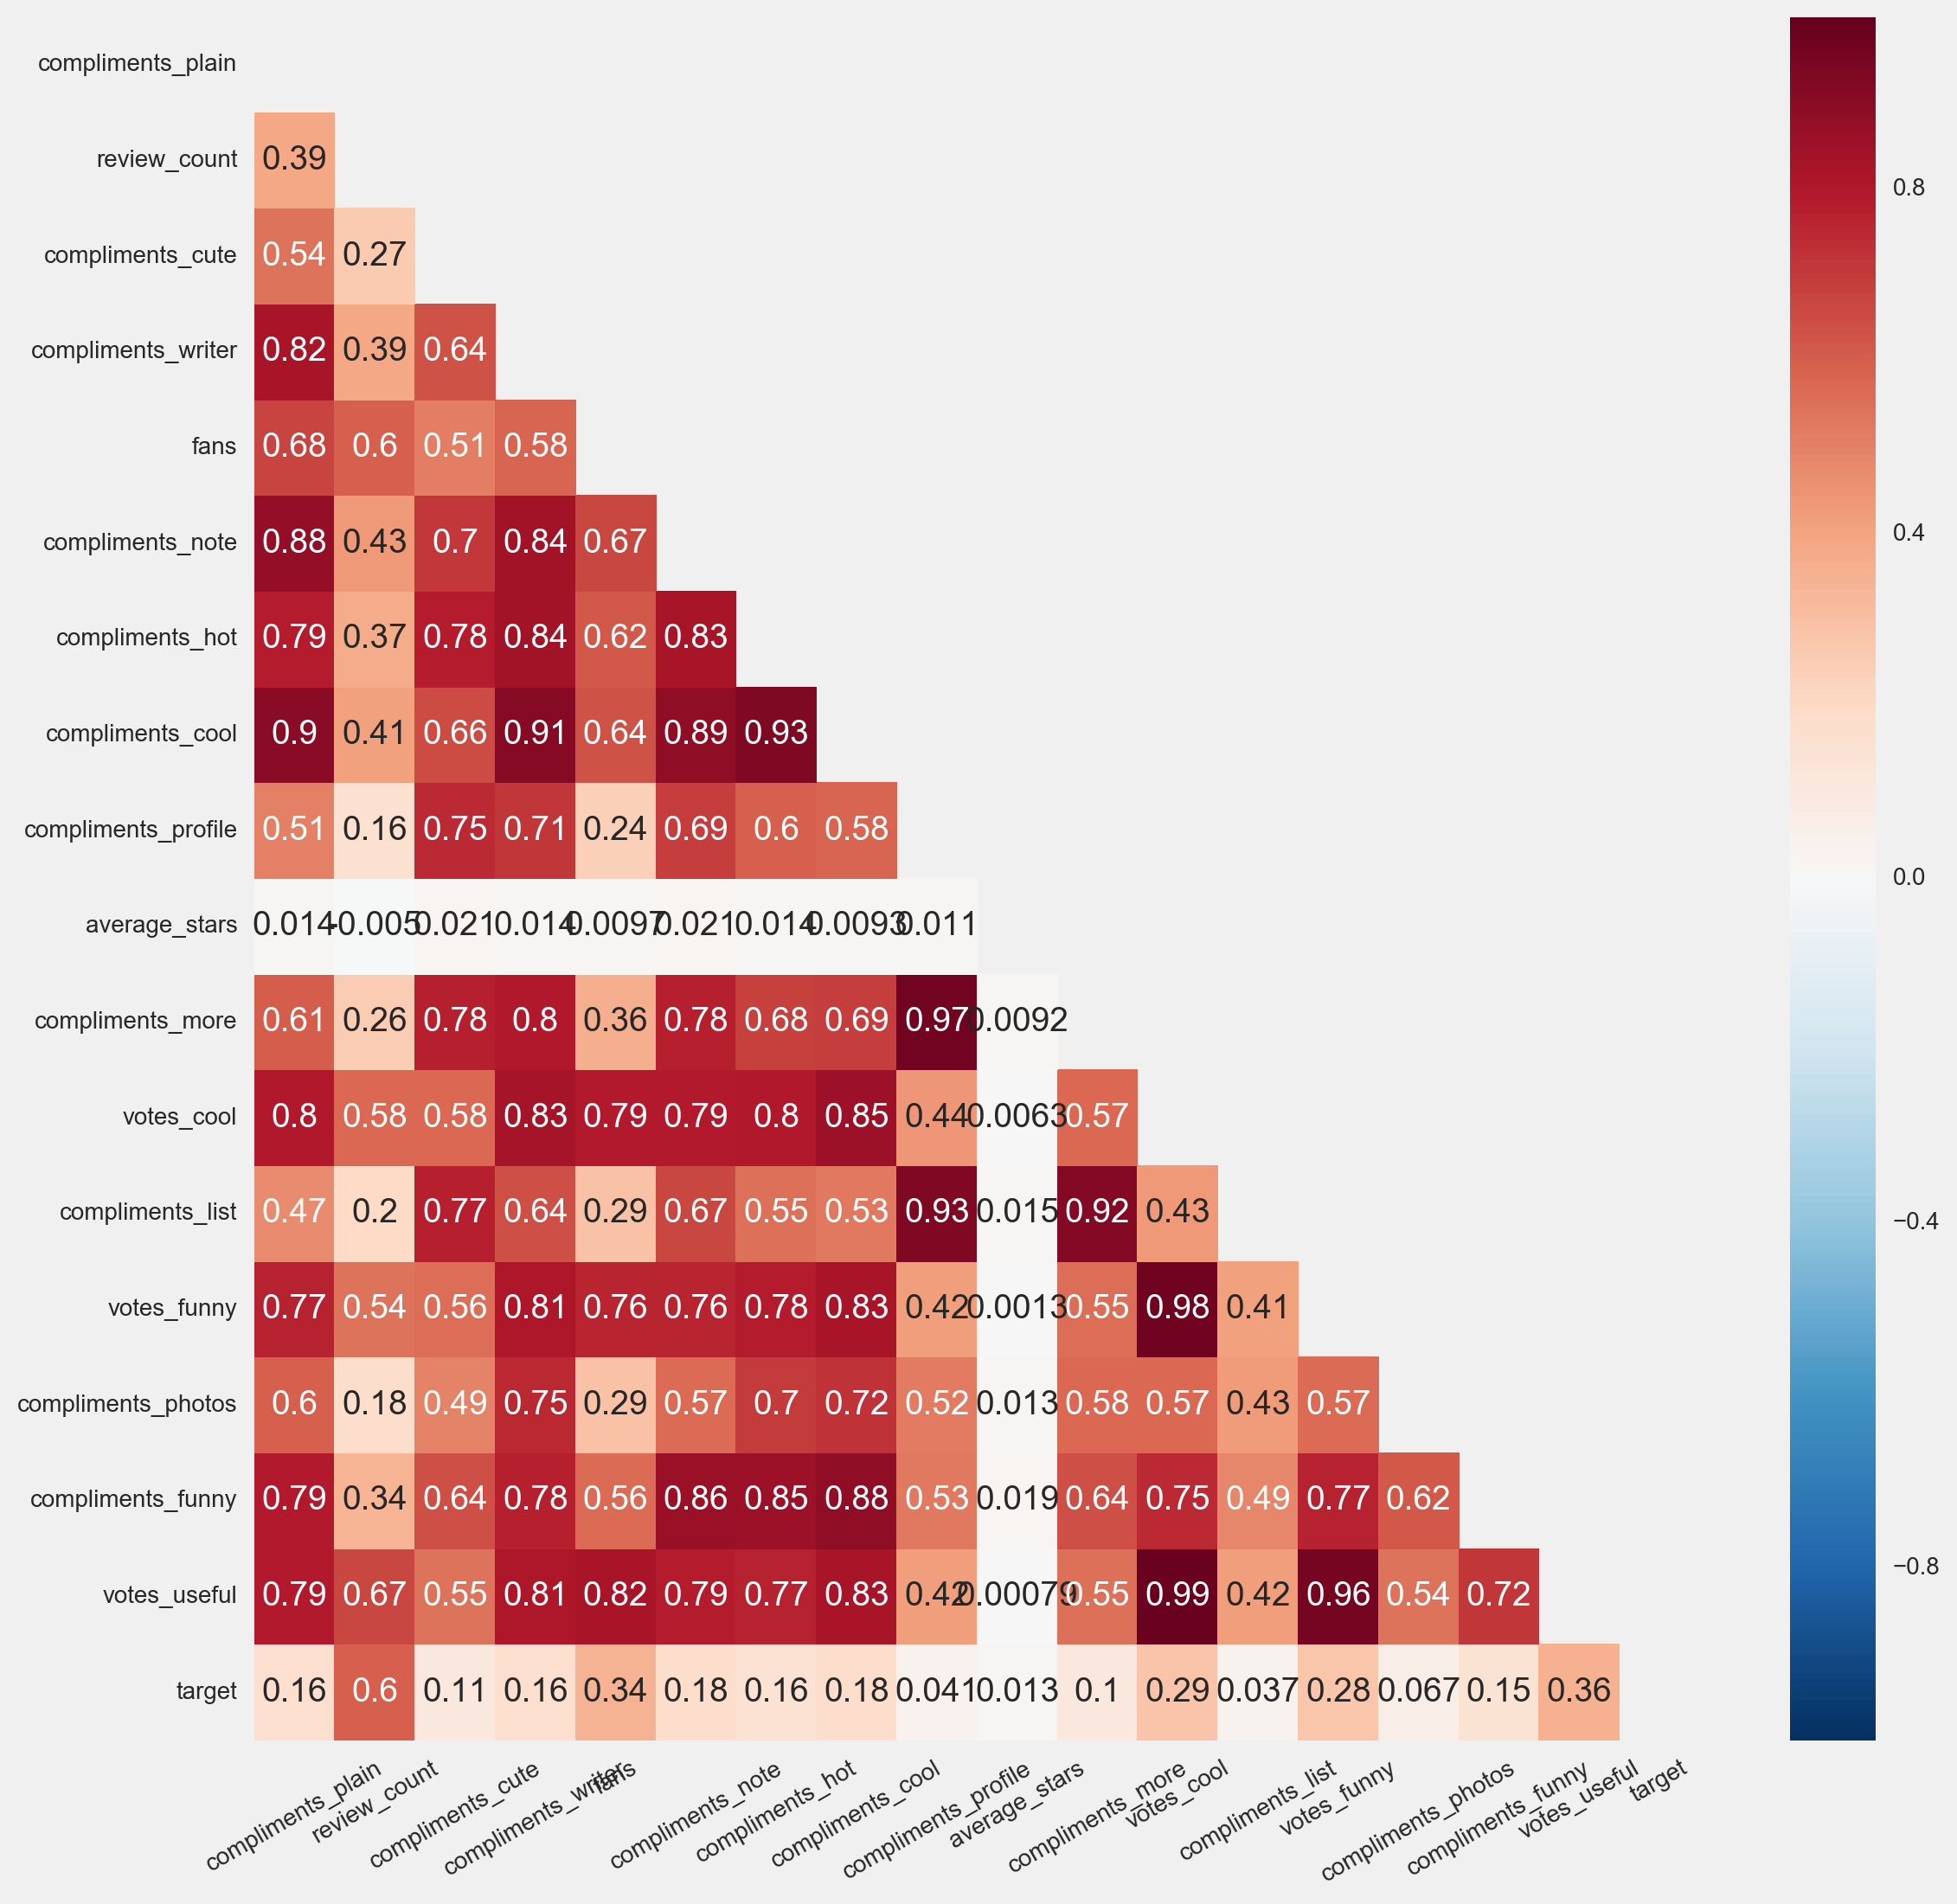

In [253]:
correlation_heat_map(users)

In [255]:
users.fillna()

,yelping_since,compliments_plain,review_count,compliments_cute,compliments_writer,fans,compliments_note,compliments_hot,compliments_cool,compliments_profile,...,elite,name,user_id,votes_cool,compliments_list,votes_funny,compliments_photos,compliments_funny,votes_useful,target
0,2015-01,0.0,1,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Scott,dMeSxE7S6Yxhz3cBgd6Sjw,0,0.0,0,0.0,0.0,0,0
1,2015-01,0.0,1,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Diego,c-e0BxGy3eNtKzKDrrHyGw,0,0.0,0,0.0,0.0,0,0
2,2015-01,0.0,2,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Katie,tO-IKvmHn9kGobTcVweTeA,0,0.0,0,0.0,0.0,0,0
3,2015-01,0.0,9,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Ross,soPELsow5JAqNSYCUmntJg,2,0.0,1,0.0,0.0,0,0
4,2015-01,0.0,2,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Pam,RR6dZa6dkrcgjKvEnI-Myw,0,0.0,0,0.0,0.0,0,0
5,2015-01,0.0,2,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Vishal,QlZcJoNxBqT4Mc9MDZrBsA,1,0.0,0,0.0,0.0,0,0
6,2015-01,0.0,2,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Daniel,CslyedYDBFOVhLkfXd4K0w,0,0.0,0,0.0,0.0,0,0
7,2015-01,0.0,3,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Dave,ndxvx9-h-OGccs-GmmBrMw,0,0.0,0,0.0,0.0,0,0
8,2015-01,0.0,1,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Lyan,2Sy0_vujNiX1SAZofg6vEg,0,0.0,0,0.0,0.0,0,0
9,2015-01,0.0,3,0.0,0.0,0,0.0,0.0,0.0,0.0,...,[],Breezy,7LLi1Uz_rTH1tpUO4G7l1A,0,0.0,0,0.0,0.0,0,0


In [441]:
#Loading up Patsy with the variables that seem to have stronger correlations with our target variable.

import patsy

y, X = patsy.dmatrices("target ~ compliments_plain + review_count + compliments_cute + compliments_writer + \
                       fans + compliments_note + compliments_hot + \
                       average_stars + compliments_more + votes_cool + votes_funny + \
                        votes_useful - 1", data=users, return_type="dataframe")

y = y.values.ravel()

print X.shape
print y.shape

(9009, 12)
(9009,)


In [442]:
ss = StandardScaler()

Xn = ss.fit_transform(X)

lr_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(0.0001, 1000, 50)
}

lr_gs = GridSearchCV(LogisticRegression(), lr_params, cv=5, verbose=1)

lr_gs.fit(Xn, y)
print lr_gs.best_params_
best_lr = lr_gs.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   30.2s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.1min finished


{'penalty': 'l1', 'C': 20.408261224489795, 'solver': 'liblinear'}


In [443]:
print 'Logistic Regression:'
print best_lr

print 'Baseline accuracy:', np.mean(y)

Logistic Regression:
LogisticRegression(C=20.408261224489795, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Baseline accuracy: 0.835830835831


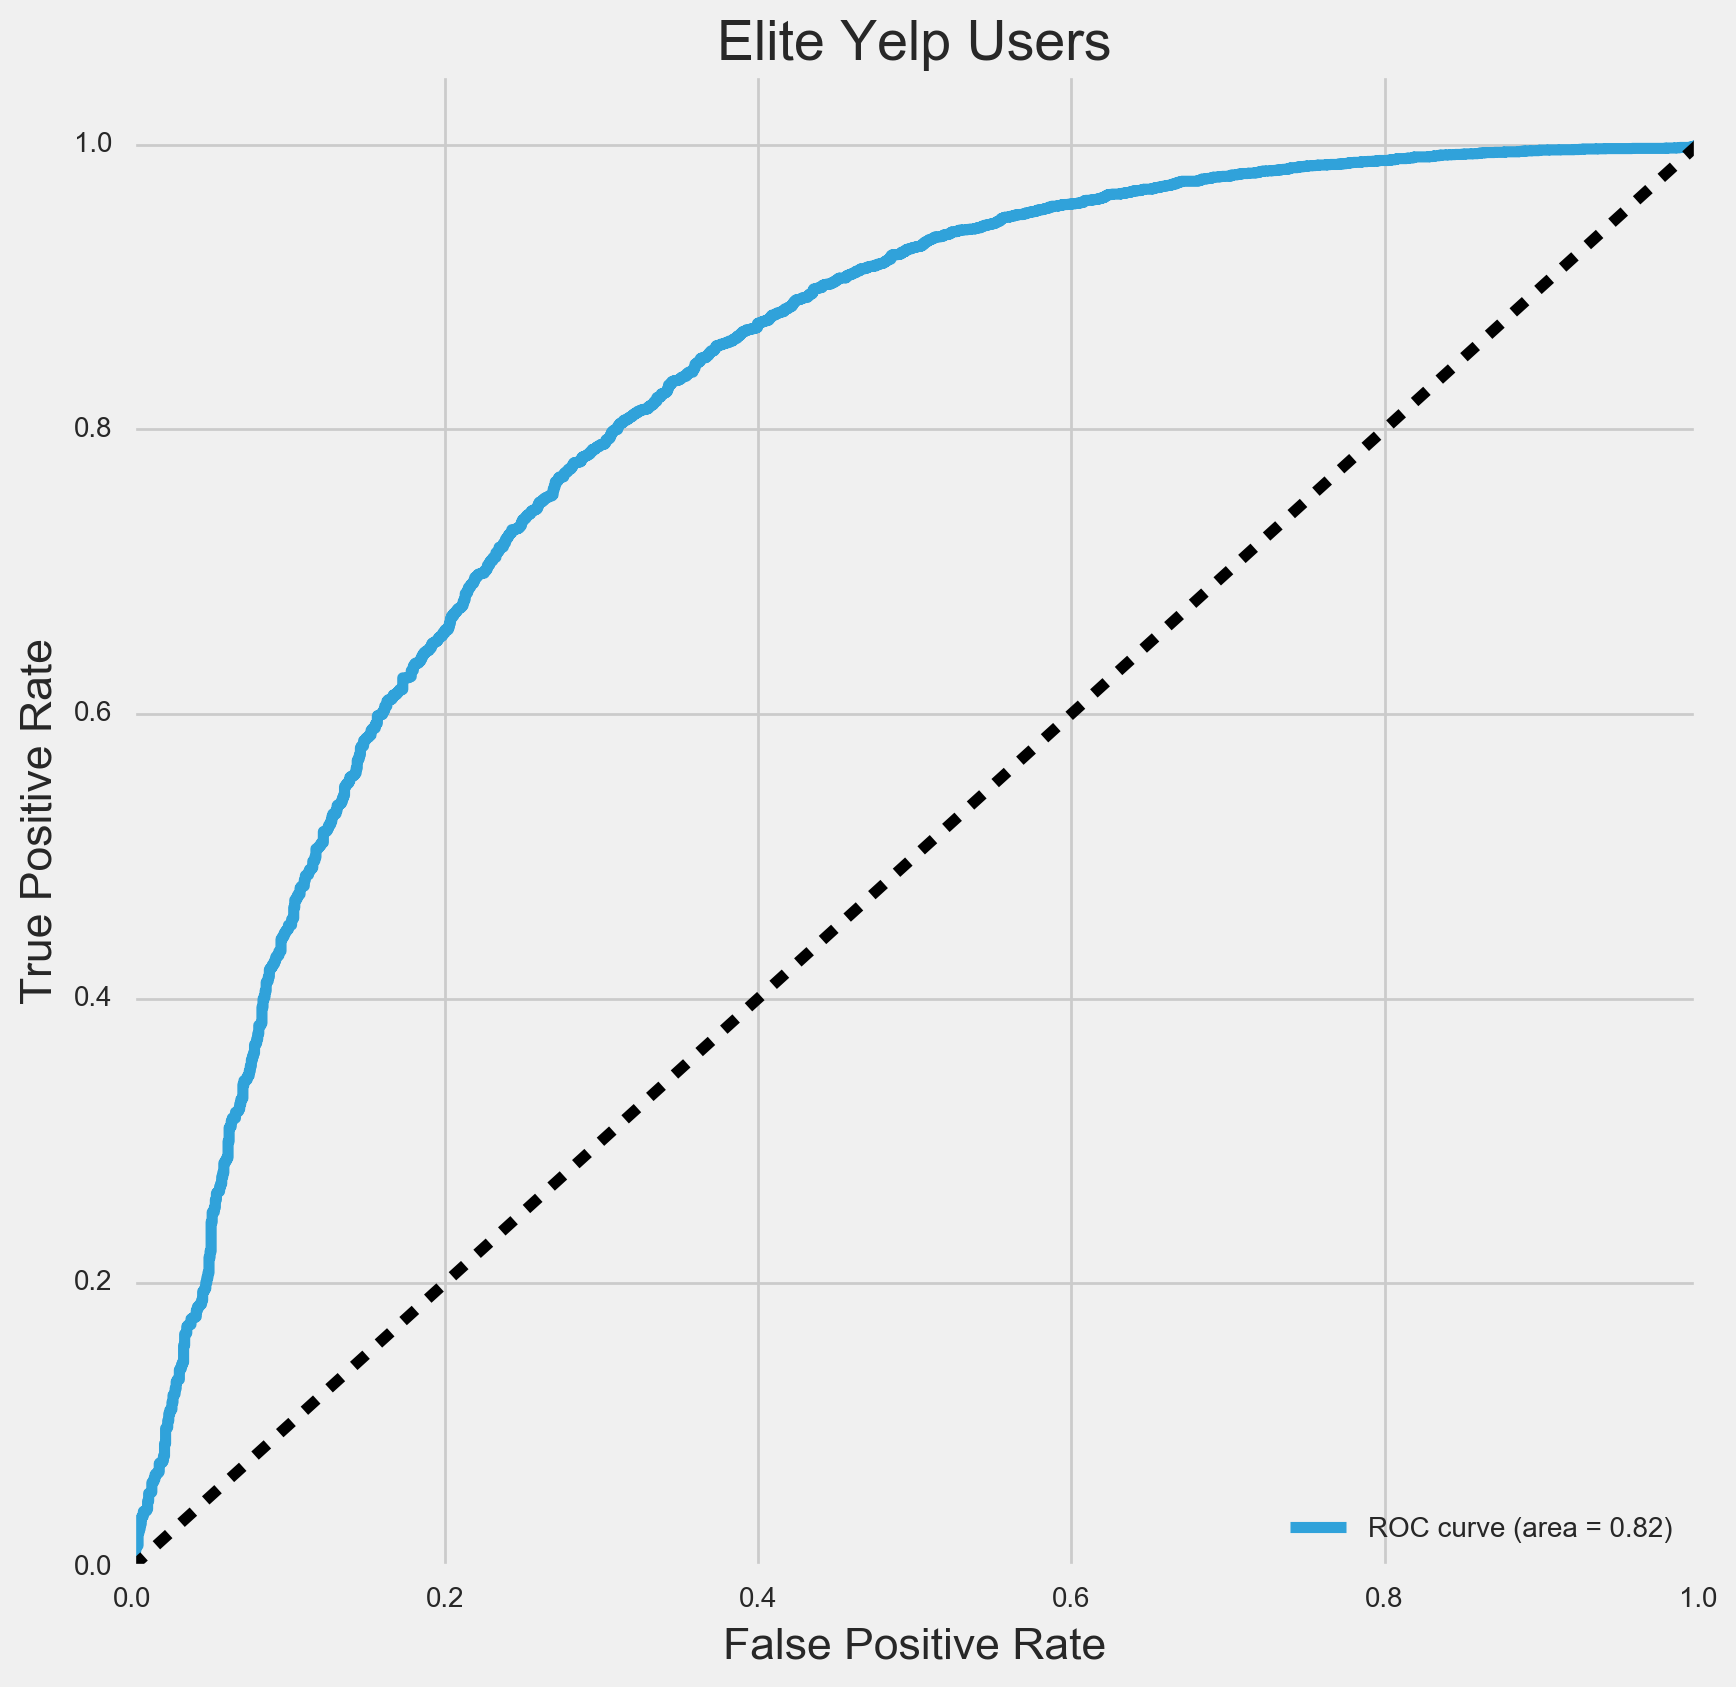

In [445]:
#Plotted my ROC, but was under my baseline accuracy by ~ 0.01. Probably could remove some of the noise in my model a
#little bit more to improve my score.

from sklearn.metrics import roc_curve, auc

Xc = X - X.mean()

lr_centered = LogisticRegression()
lr_centered.fit(Xc, y)

y_pp = lr_centered.predict_proba(Xc)

fpr, tpr, _ = roc_curve(y, y_pp[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[9,9])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Elite Yelp Users', fontsize=20)
plt.legend(loc="lower right")
plt.show()

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?